In [3]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [4]:
%load_ext autoreload
%autoreload 2
from data.api_fetcher import ApiFetcher

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%reload_ext autoreload
api = ApiFetcher(starting_year=2015, ending_year=2025)
df = api.create_numeric_with_team_ids()
print(df.columns)

Index(['home_fga', 'home_fg_pct', 'home_fg3a', 'home_fg3_pct', 'home_oreb',
       'home_dreb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf',
       'home_pts', 'away_fga', 'away_fg_pct', 'away_fg3a', 'away_fg3_pct',
       'away_oreb', 'away_dreb', 'away_ast', 'away_stl', 'away_blk',
       'away_tov', 'away_pf', 'away_pts', 'home_team_season_id',
       'away_team_season_id', 'date'],
      dtype='object')


In [5]:
def prepare_embedding_dataset(df, 
                               home_id_col='home_team_season_id', 
                               away_id_col='away_team_season_id',
                               target_cols=('home_pts', 'away_pts'),
                               date_col='date'):
    
    #prep target
    y = df[target_cols[0]] + df[target_cols[1]] 
    y = y.values.astype(np.float32)

    #extract ids, leave only numeric data
    exclude_cols = [home_id_col, away_id_col] + list(target_cols) + [date_col]
    numeric_cols = []
    for col in df.columns:
            if col not in exclude_cols:
                # Check if column is numeric and can be converted to float
                if pd.api.types.is_numeric_dtype(df[col]):
                    numeric_cols.append(col)
    
    print(f"Using numeric columns: {numeric_cols}")

    #extract and normalise num features (must be  numpy tensors)

    X_numeric = df[numeric_cols].values.astype(np.float32)
    scaler = StandardScaler()
    X_numeric = scaler.fit_transform(X_numeric)

    # Extract team IDs
    X_home_id = df[home_id_col].values.astype(np.int32)
    X_away_id = df[away_id_col].values.astype(np.int32)
    
    return X_numeric, X_home_id, X_away_id, y, scaler




In [6]:
#X_numeric, X_home_id, X_away_id, y, scaler = prepare_embedding_dataset(df)

#print("X_numeric shape:", X_numeric.shape)
#print("Home IDs shape:", X_home_id.shape)
#print("Away IDs shape:", X_away_id.shape)
#print("y shape:", y.shape)


In [7]:
import torch
import torch.nn as nn

class NBAEmbeddingModel(nn.Module):
    def __init__(self, num_numeric_features, num_teams, embedding_dim=8):
        super(NBAEmbeddingModel, self).__init__()
        
        # Embedding layers for team IDs
        self.home_embedding = nn.Embedding(num_teams, embedding_dim)
        self.away_embedding = nn.Embedding(num_teams, embedding_dim)
        
        # First hidden layer: (numeric features + 2 embeddings) → 64 neurons
        self.fc1 = nn.Linear(num_numeric_features + embedding_dim * 2, 64)
        
        # Second hidden layer: 64 → 32 neurons
        self.fc2 = nn.Linear(64, 32)
        
        # Output layer: 32 → 1 (predict total points)
        self.output = nn.Linear(32, 1)
        
        # Activation
        self.relu = nn.ReLU()

    def forward(self, numeric_features, home_ids, away_ids):
        # Get embeddings
        home_emb = self.home_embedding(home_ids)   # shape: (batch_size, embedding_dim)
        away_emb = self.away_embedding(away_ids)   # shape: (batch_size, embedding_dim)
        
        # Concatenate numeric + embeddings
        x = torch.cat([numeric_features, home_emb, away_emb], dim=1)
        
        # Pass through hidden layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        
        # Output (linear, no activation for regression)
        return self.output(x)


In [8]:
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# 1. Prepare dataset
X_numeric, X_home_id, X_away_id, y, scaler = prepare_embedding_dataset(df)

# Convert date column to datetime
dates = pd.to_datetime(df['date'])

# Sort by date
sorted_idx = dates.argsort()
X_numeric = X_numeric[sorted_idx]
X_home_id = X_home_id[sorted_idx]
X_away_id = X_away_id[sorted_idx]
y = y[sorted_idx]

# Split by date: last 20% as test
split_idx = int(len(df) * 0.8)

X_numeric_train, X_numeric_test = X_numeric[:split_idx], X_numeric[split_idx:]
X_home_train, X_home_test = X_home_id[:split_idx], X_home_id[split_idx:]
X_away_train, X_away_test = X_away_id[:split_idx], X_away_id[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_numeric_train = torch.tensor(X_numeric_train, dtype=torch.float32)
X_numeric_test = torch.tensor(X_numeric_test, dtype=torch.float32)
X_home_train = torch.tensor(X_home_train, dtype=torch.long)
X_home_test = torch.tensor(X_home_test, dtype=torch.long)
X_away_train = torch.tensor(X_away_train, dtype=torch.long)
X_away_test = torch.tensor(X_away_test, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_numeric_train, X_home_train, X_away_train, y_train)
test_dataset = TensorDataset(X_numeric_test, X_home_test, X_away_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Using numeric columns: ['home_fga', 'home_fg_pct', 'home_fg3a', 'home_fg3_pct', 'home_oreb', 'home_dreb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf', 'away_fga', 'away_fg_pct', 'away_fg3a', 'away_fg3_pct', 'away_oreb', 'away_dreb', 'away_ast', 'away_stl', 'away_blk', 'away_tov', 'away_pf']


In [9]:
num_numeric_features = X_numeric_train.shape[1]
num_teams = max(X_home_id.max(), X_away_id.max()) + 1  # IDs start at 0
model = NBAEmbeddingModel(num_numeric_features, num_teams, embedding_dim=8)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

NBAEmbeddingModel(
  (home_embedding): Embedding(300, 8)
  (away_embedding): Embedding(300, 8)
  (fc1): Linear(in_features=38, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [35]:
def move_batch_to_device(batch, device):
    return [b.to(device) for b in batch]


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import copy
import numpy as np

# --- Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Prepare dataset (numeric features already extracted) ---
X_numeric, X_home_id, X_away_id, y, scaler = prepare_embedding_dataset(df)

# Sort by date
dates = pd.to_datetime(df['date'])
sorted_idx = dates.argsort()
X_numeric = X_numeric[sorted_idx]
X_home_id = X_home_id[sorted_idx]
X_away_id = X_away_id[sorted_idx]
y = y[sorted_idx]

# Split train/test (last 20% test)
split_idx = int(len(df) * 0.8)
X_numeric_train, X_numeric_test = X_numeric[:split_idx], X_numeric[split_idx:]
X_home_train, X_home_test = X_home_id[:split_idx], X_home_id[split_idx:]
X_away_train, X_away_test = X_away_id[:split_idx], X_away_id[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- Normalize numeric features ---
X_numeric_train = scaler.fit_transform(X_numeric_train)
X_numeric_test = scaler.transform(X_numeric_test)

# --- Normalize target ---
y_mean = y_train.mean()
y_std = y_train.std()
y_train_norm = (y_train - y_mean) / y_std
y_test_norm = (y_test - y_mean) / y_std

# --- Convert to tensors & move to device ---
X_numeric_train = torch.tensor(X_numeric_train, dtype=torch.float32).to(device)
X_home_train = torch.tensor(X_home_train, dtype=torch.long).to(device)
X_away_train = torch.tensor(X_away_train, dtype=torch.long).to(device)
y_train_norm = torch.tensor(y_train_norm, dtype=torch.float32).unsqueeze(1).to(device)

X_numeric_test = torch.tensor(X_numeric_test, dtype=torch.float32).to(device)
X_home_test = torch.tensor(X_home_test, dtype=torch.long).to(device)
X_away_test = torch.tensor(X_away_test, dtype=torch.long).to(device)
y_test_norm = torch.tensor(y_test_norm, dtype=torch.float32).unsqueeze(1).to(device)

# --- Train/validation split from training set ---
val_idx = int(len(X_numeric_train) * 0.8)
X_num_train_only = X_numeric_train[:val_idx]
X_home_train_only = X_home_train[:val_idx]
X_away_train_only = X_away_train[:val_idx]
y_train_only = y_train_norm[:val_idx]

X_num_val = X_numeric_train[val_idx:]
X_home_val = X_home_train[val_idx:]
X_away_val = X_away_train[val_idx:]
y_val = y_train_norm[val_idx:]

train_dataset = TensorDataset(X_num_train_only, X_home_train_only, X_away_train_only, y_train_only)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# --- Model ---
num_numeric_features = X_numeric_train.shape[1]
num_teams = max(X_home_id.max(), X_away_id.max()) + 1
model = NBAEmbeddingModel(num_numeric_features, num_teams, embedding_dim=8).to(device)

# --- Loss, optimizer, scheduler ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
total_steps = len(train_loader) * 100  # assuming 100 epochs
scheduler = OneCycleLR(optimizer, max_lr=0.001, total_steps=total_steps, pct_start=0.2)

# --- Early stopping ---
best_val_loss = float('inf')
patience = 20
patience_counter = 0
best_model_state = None
num_epochs = 100

# --- Training loop ---
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    
    for X_num_batch, X_home_batch, X_away_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_num_batch, X_home_batch, X_away_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item() * X_num_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # --- Validation ---
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_num_val, X_home_val, X_away_val)
        val_loss = criterion(val_outputs, y_val).item()
    
    # --- Early stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = copy.deepcopy(model.state_dict())
    else:
        patience_counter += 1

    print(f"Epoch {epoch:03d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}. Best val loss: {best_val_loss:.4f}")
        break

# --- Load best model ---
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with val loss: {best_val_loss:.4f}")

# --- Evaluate on test set ---
model.eval()
with torch.no_grad():
    test_outputs_norm = model(X_numeric_test, X_home_test, X_away_test)
    test_outputs = test_outputs_norm * y_std + y_mean  # revert normalization
    test_loss = ((test_outputs - y_test.reshape(-1,1).to(device))**2).mean().item()
    print(f"Final Test Loss: {test_loss:.4f}")


Using numeric columns: ['home_fga', 'home_fg_pct', 'home_fg3a', 'home_fg3_pct', 'home_oreb', 'home_dreb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf', 'away_fga', 'away_fg_pct', 'away_fg3a', 'away_fg3_pct', 'away_oreb', 'away_dreb', 'away_ast', 'away_stl', 'away_blk', 'away_tov', 'away_pf']
Epoch 001: Train Loss: 0.9297, Val Loss: 1.0361, LR: 0.000046
Epoch 002: Train Loss: 0.8237, Val Loss: 0.9291, LR: 0.000064
Epoch 003: Train Loss: 0.5803, Val Loss: 0.5667, LR: 0.000092
Epoch 004: Train Loss: 0.2566, Val Loss: 0.2124, LR: 0.000132
Epoch 005: Train Loss: 0.1389, Val Loss: 0.1369, LR: 0.000181
Epoch 006: Train Loss: 0.1040, Val Loss: 0.1182, LR: 0.000238
Epoch 007: Train Loss: 0.0904, Val Loss: 0.1017, LR: 0.000302
Epoch 008: Train Loss: 0.0846, Val Loss: 0.1027, LR: 0.000372
Epoch 009: Train Loss: 0.0806, Val Loss: 0.0980, LR: 0.000445
Epoch 010: Train Loss: 0.0778, Val Loss: 0.0932, LR: 0.000520
Epoch 011: Train Loss: 0.0756, Val Loss: 0.0986, LR: 0.000595
Epoch 012: T

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [20]:
def evaluate_model(model, test_loader, device):
    
    model.eval()
    criterion = nn.MSELoss()
    test_loss = 0.0
    preds_all = []
    y_all = []

    with torch.no_grad():
        for X_num_batch, X_home_batch, X_away_batch, y_batch in test_loader:
            # Move to device
            X_num_batch = X_num_batch.to(device)
            X_home_batch = X_home_batch.to(device)
            X_away_batch = X_away_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_num_batch, X_home_batch, X_away_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_num_batch.size(0)

            preds_all.append(outputs.cpu())
            y_all.append(y_batch.cpu())

    test_loss /= len(test_loader.dataset)
    preds_all = torch.cat(preds_all, dim=0).numpy().flatten()
    y_all = torch.cat(y_all, dim=0).numpy().flatten()
    
    rmse = np.sqrt(test_loss)

    print(f"Test MSE: {test_loss:.4f}, RMSE: {rmse:.4f}")
    return preds_all, y_all


In [21]:
preds, y_true = evaluate_model(model, test_loader, device)

# Quick sanity check
for i in range(5):
    print(f"True: {y_true[i]:.1f}, Predicted: {preds[i]:.1f}")


Test MSE: 85.6346, RMSE: 9.2539
True: 184.0, Predicted: 179.2
True: 259.0, Predicted: 263.3
True: 247.0, Predicted: 240.9
True: 211.0, Predicted: 205.2
True: 203.0, Predicted: 189.9


In [22]:
def get_team_embeddings(model, device):
    """
    Returns a dictionary with team_id as key and embedding vector as value.
    """
    model.eval()
    # Move embeddings to CPU and convert to numpy
    home_embeddings = model.home_embedding.weight.detach().cpu().numpy()
    away_embeddings = model.away_embedding.weight.detach().cpu().numpy()
    
    # Average them since home and away should be more or less similiar
    combined_embeddings = (home_embeddings + away_embeddings) / 2

    # Create a dictionary: team_id -> embedding vector
    team_embedding_dict = {team_id: combined_embeddings[team_id] 
                           for team_id in range(combined_embeddings.shape[0])}
    return team_embedding_dict


In [23]:
team_embeddings = get_team_embeddings(model, device)
print("Embedding for team 0:", team_embeddings[0])


Embedding for team 0: [ 0.01235467  0.530424   -0.36219403 -1.3354107   0.43266487  0.6173635
  1.017063    0.32137904]


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

def train_and_plot(model, train_loader, test_loader, device,
                   num_epochs=50, lr=0.001):
    """
    Trains the NBAEmbeddingModel, plots train/test loss per epoch.
    
    Returns:
        train_losses, test_losses
    """
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    def move_batch_to_device(batch, device):
        return [b.to(device) for b in batch]

    for epoch in range(1, num_epochs + 1):
        # --- Training ---
        model.train()
        train_loss = 0.0
        for X_num_batch, X_home_batch, X_away_batch, y_batch in train_loader:
            X_num_batch, X_home_batch, X_away_batch, y_batch = move_batch_to_device(
                [X_num_batch, X_home_batch, X_away_batch, y_batch], device
            )

            optimizer.zero_grad()
            outputs = model(X_num_batch, X_home_batch, X_away_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_num_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # --- Test evaluation ---
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_num_batch, X_home_batch, X_away_batch, y_batch in test_loader:
                X_num_batch, X_home_batch, X_away_batch, y_batch = move_batch_to_device(
                    [X_num_batch, X_home_batch, X_away_batch, y_batch], device
                )
                outputs = model(X_num_batch, X_home_batch, X_away_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item() * X_num_batch.size(0)
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        # Print progress every 5 epochs
        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # --- Plotting ---
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Training & Test Loss (lr={lr})')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, test_losses


Epoch 001/50, Train Loss: 1475.2484, Test Loss: 1057.6545
Epoch 005/50, Train Loss: 171.8005, Test Loss: 221.1670
Epoch 010/50, Train Loss: 63.4901, Test Loss: 96.5397
Epoch 015/50, Train Loss: 41.9949, Test Loss: 78.9507
Epoch 020/50, Train Loss: 35.2879, Test Loss: 72.5263
Epoch 025/50, Train Loss: 31.8676, Test Loss: 61.1427
Epoch 030/50, Train Loss: 29.5100, Test Loss: 63.2509
Epoch 035/50, Train Loss: 28.0944, Test Loss: 63.9356
Epoch 040/50, Train Loss: 26.8665, Test Loss: 72.5600
Epoch 045/50, Train Loss: 25.4941, Test Loss: 62.4166
Epoch 050/50, Train Loss: 24.7693, Test Loss: 63.1315


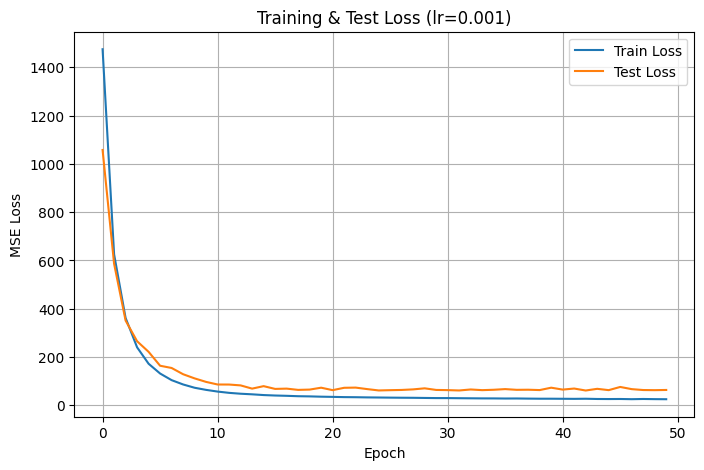

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses, test_losses = train_and_plot(
    model,
    train_loader,
    test_loader,
    device=device,
    num_epochs=50,
    lr=0.001
)


Epoch 001/100, Train Loss: 24.8052, Test Loss: 63.9168
Epoch 005/100, Train Loss: 24.0020, Test Loss: 74.5567
Epoch 010/100, Train Loss: 23.2154, Test Loss: 70.2557
Epoch 015/100, Train Loss: 22.7767, Test Loss: 74.8892
Epoch 020/100, Train Loss: 22.1497, Test Loss: 73.4958
Epoch 025/100, Train Loss: 21.7106, Test Loss: 74.8240
Epoch 030/100, Train Loss: 21.0715, Test Loss: 78.7691
Epoch 035/100, Train Loss: 20.4110, Test Loss: 74.2864
Epoch 040/100, Train Loss: 20.3236, Test Loss: 75.7219
Epoch 045/100, Train Loss: 19.6796, Test Loss: 87.9954
Epoch 050/100, Train Loss: 19.4206, Test Loss: 82.0978
Epoch 055/100, Train Loss: 19.0826, Test Loss: 72.5732
Epoch 060/100, Train Loss: 18.9312, Test Loss: 71.5168
Epoch 065/100, Train Loss: 18.6503, Test Loss: 76.8653
Epoch 070/100, Train Loss: 18.6265, Test Loss: 88.1362
Epoch 075/100, Train Loss: 17.8713, Test Loss: 93.7677
Epoch 080/100, Train Loss: 17.6182, Test Loss: 76.9116
Epoch 085/100, Train Loss: 17.2208, Test Loss: 89.1505
Epoch 090/

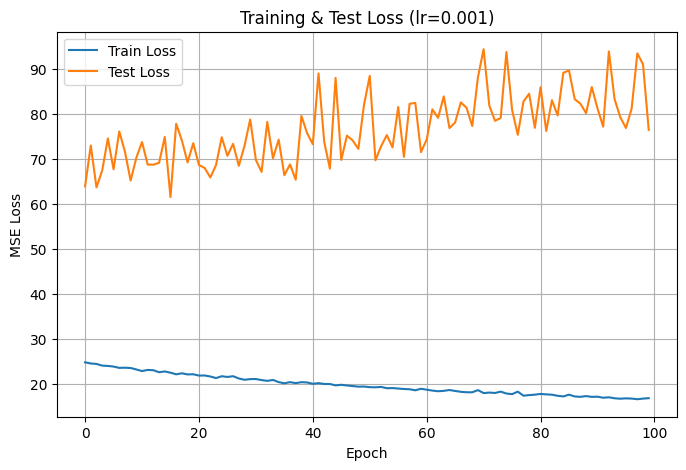

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses, test_losses = train_and_plot(
    model,
    train_loader,
    test_loader,
    device=device,
    num_epochs=100,
    lr=0.001
)


In [7]:
%reload_ext autoreload
api = ApiFetcher(starting_year=2015, ending_year=2025)
df = api.df_with_id()
print(df.head)

<bound method NDFrame.head of        home_fga  away_fga  home_fg_pct  away_fg_pct  home_fg3a  away_fg3a  \
0            82        96        0.451        0.385         27         29   
1            87        94        0.425        0.404         19         29   
2            96        83        0.427        0.422         30         18   
3            86        93        0.349        0.452         18         23   
4            86        93        0.488        0.484         19         15   
...         ...       ...          ...          ...        ...        ...   
11968        74        86        0.514        0.430         35         42   
11969        90        85        0.389        0.376         45         39   
11970        98        89        0.469        0.449         43         42   
11971       104        87        0.500        0.437         40         28   
11972        84        97        0.512        0.474         32         39   

       home_fg3_pct  away_fg3_pct  home_oreb 